# Setup

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

from torchtext import data
from torchtext.vocab import GloVe

from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

sns.set(style="whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Introduction

There are many featurees when it comes to wine, for example, where the wine is from, what year was it made, what type of wine it is etc that go into the quality of said wine. The goal of the project is to create and compare several models that take in these wine features and predict a wine's rating. 

In this project, we will use this kaggle wine review dataset (https://www.kaggle.com/zynicide/wine-reviews). 

## Load data

In [ ]:
# download the data from the above link and load into google drive

DATA_FILE_PATH = ''
df = pd.read_csv(DATA_FILE_PATH)

In [ ]:
df.head(10)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [ ]:
print("Size of dataset", len(df))

Size of dataset 129971


The dataset has information about 100,000+ wines, including the name of the wine, its price, varying degress of specificity as to where the wine has come from (country, province, winery etc), a wine review from a taster, and a wine score. We will be using the wine score from this dataset as the labels to predict.

Additionally, with varying degrees of geographic specificity, for this analysis, we will simply use country level, as many of these features may not be present for certain wines.

## Cleaning data

In [ ]:
df = df.drop(['Unnamed: 0'], axis=1)
df = df.dropna(subset=['price', 'country', 'points', 'variety'])

title_dup = df['title'].duplicated()
df = df.drop(title_dup[title_dup].index)

df = df.drop_duplicates()

print("Size of dataset after cleaning", len(df))

Size of dataset after cleaning 110582


# EDA

In this section we will perform our exploratory data analysis. We are going to examine certain features of the data, and see how some of them the correlate against score.

## Points

First we will examine the distribution of the points.



In [ ]:
# Statistics for points distribution
df["points"].describe()

count    110582.000000
mean         88.416370
std           3.100663
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

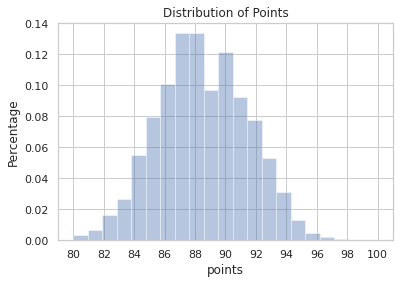

In [ ]:
# Plotting the distribution for points

sns.distplot(df["points"], bins=21, kde=False, norm_hist=True)
plt.title("Distribution of Points")
plt.xticks(range(80, 101,2))
plt.ylabel("Percentage")
plt.show()

From the above analysis, we can see that while points are given on a 0-100 scale, the range of points is only from 80-100. Within this range though, they appear to follow a rough normal distribution. Given that the scores are skewed in their current range, it could be a good idea to normalize this.

## Country

Next, let us examine the countries that these wines come from.

In [ ]:
# Here we count the number of countries in the dataset, and normalize the information
country_count = df.groupby(['country']).size().sort_values(ascending=False)
country_norm = country_count / country_count.sum()
len(country_count)

42

There are 42 countries in the dataset, which is quite a lot considering many wines one would commonly buy come from a small handful of countries (easily less than 20). Let us take a look at the distribution of these countries.

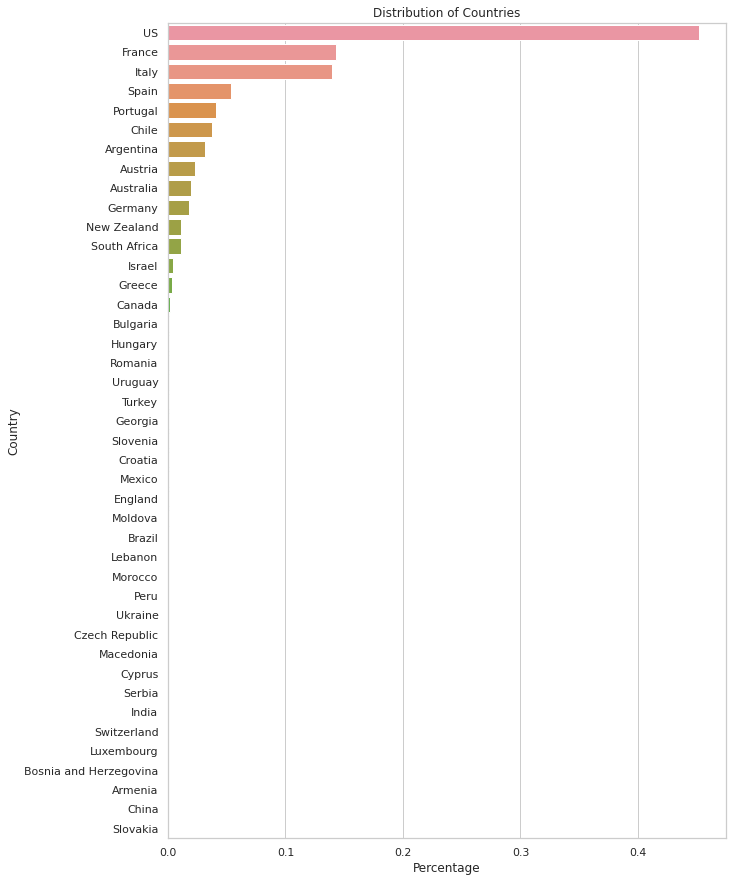

In [ ]:
# Plot a bar chart to show distribution of countries, normalized
fig, ax = plt.subplots(figsize=(10,15))
sns.barplot(country_norm.values, country_norm.index)

ax.set_title("Distribution of Countries")
ax.set_xlabel("Percentage")
ax.set_ylabel("Country")

plt.show()

As we can see, the countries represented in the dataset has a strong heavy tail distribution. The majority of wines come from a handful of countries as expected. We can also see that the dataset heavily overrepresents the US at over 40%. This feature imbalance could have implications when selecting country as an input.

#### Score across countries

Now to see if there is any relationship between the country a wine was produced from and its rating.

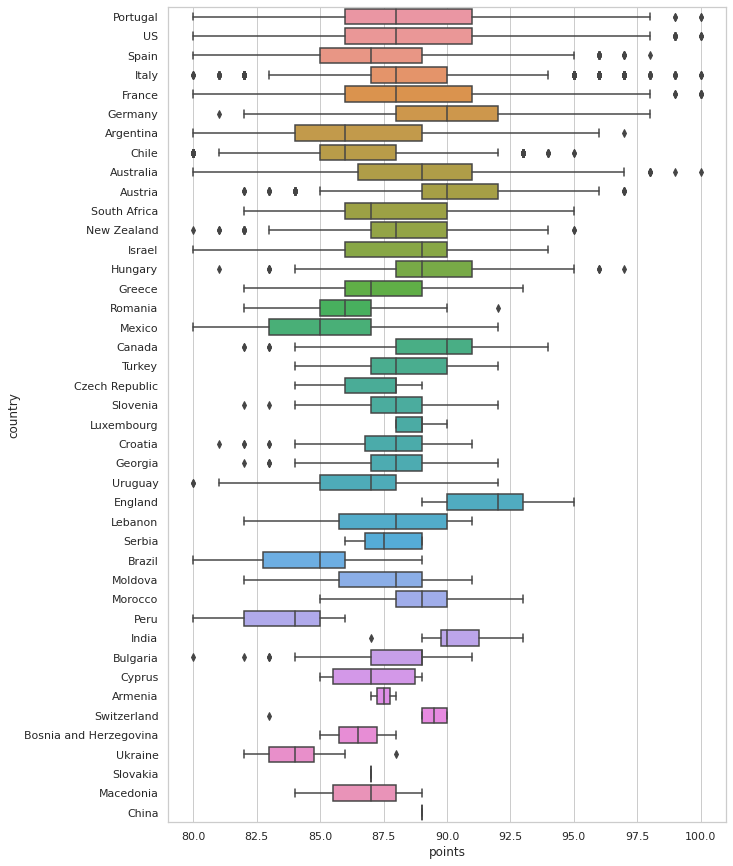

In [ ]:
# box plot of wine point rating from each country

fig, ax = plt.subplots(figsize=(10,15))
sns.boxplot(x=df['points'], y=df['country'])

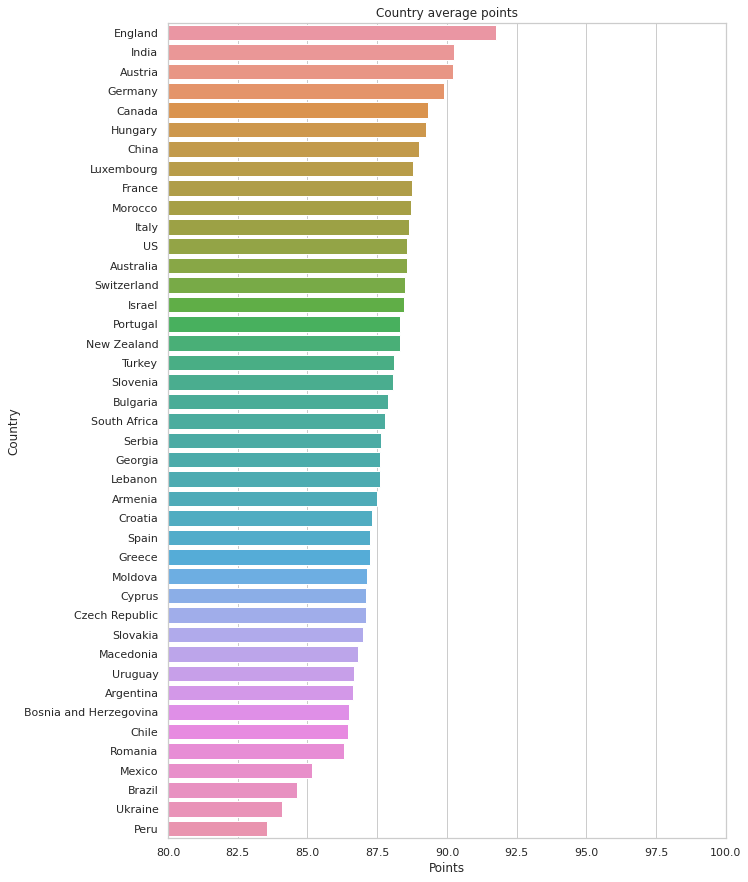

In [ ]:
#box plot the average points for wine coming from a certain country

country_mean_points = df.groupby('country').mean()['points'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,15))
sns.barplot(country_mean_points.values, country_mean_points.index)

ax.set_title("Country average points")
ax.set_xlabel("Points")
ax.set_ylabel("Country")
ax.set_xlim(left=80, right=100)

plt.show()

From the two plots we can see that there is some correlation in terms of where a wine is from and how it scores. However, the wine rating from any one country can vary a lot, with many outliers exisiting. Furthermore, it is important to keep in mind that some countries may only have a small handful of wines in this dataset, whilst others have thousands. A couple high or low scoring wines from a small sample size may not be representative, which suggests again downsampling based off country.

## Wine variety

Now we will examine the wine variety. Wine variety determines many aspects of a wine, such as its taste, texture, etc



In [ ]:
 # Find the number of varieties and also normalize for distribution
variety_count = df.groupby("variety").size().sort_values(ascending=False)
variety_norm = variety_count / variety_count.sum()
len(variety_count)

691

There are 691 varieties of wine, therefore we need to consider how to represent this feature in an efficient and meaningful manner.

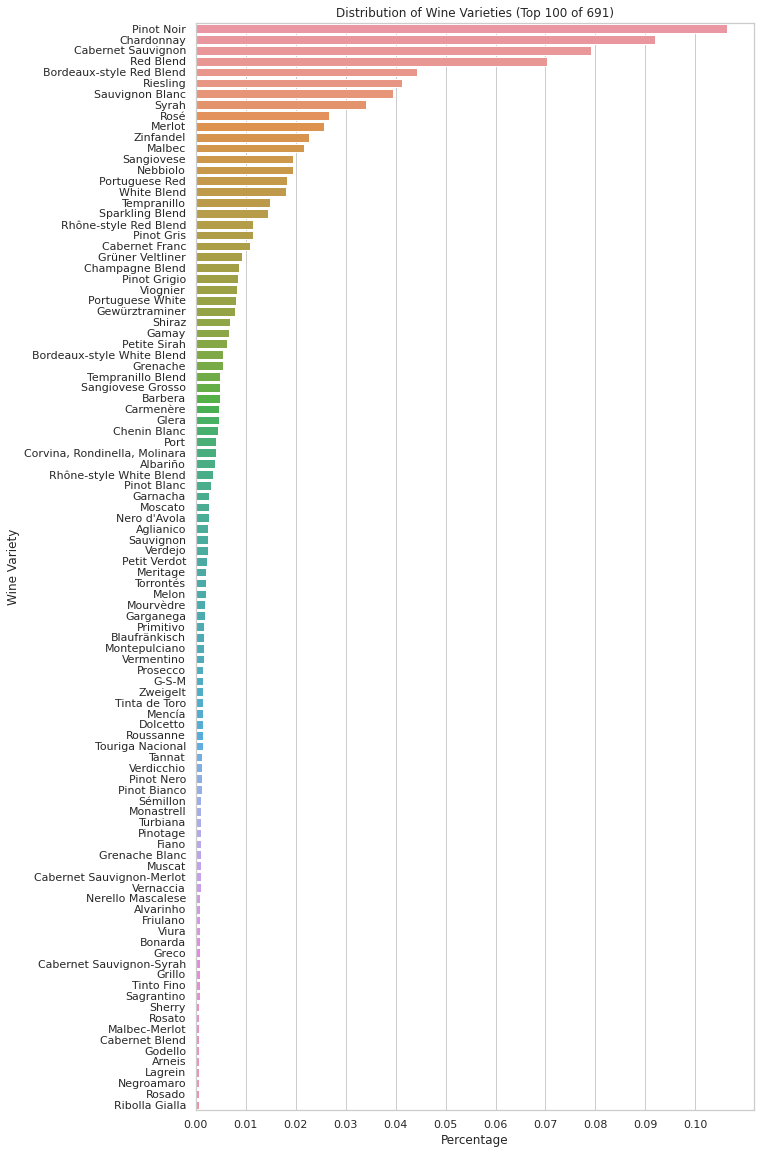

In [ ]:
#Plot distribution of the top 100 wine varieties

fig, ax = plt.subplots(figsize=(10,20))
sns.barplot(variety_norm.values[:100], variety_norm.index[:100])

ax.set_title("Distribution of Wine Varieties (Top 100 of 691)")
ax.set_xlabel("Percentage")
ax.set_ylabel("Wine Variety")
ax.set_xticks(np.arange(0, 0.11, step=0.01))

plt.show()

If there was an equal class balance, we would expect each variety to have 1/691 of the total, roughly 0.14%. Howevever we can see that again there is a heavy tail distribution, with pinot noir being the most overrepresented at roughly 10%. In including wine variety as a feature, we must also consider this class imbalance.

## Price

Now we will look at the distribution of prices of wines. Since price is a continuous variable, we can see if there are any obvious correlations between price and points.

In [ ]:
df['price'].describe()

count    110582.000000
mean         35.598153
std          41.900532
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max        3300.000000
Name: price, dtype: float64

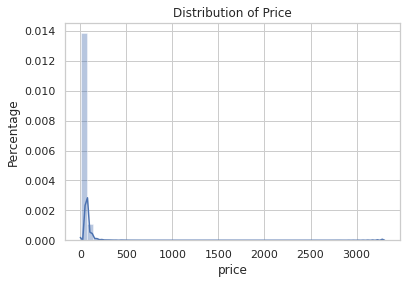

In [ ]:
#Plot distribution of price

sns.distplot(df["price"], kde=True, norm_hist=True)
plt.title("Distribution of Price")
# plt.xticks(range(80, 101,2))
plt.ylabel("Percentage")
plt.show()

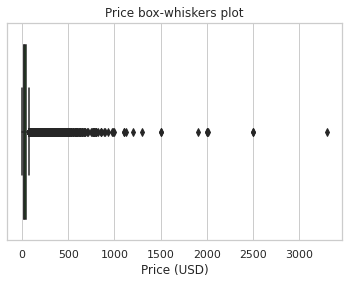

In [ ]:
# Box plot of price

bp = sns.boxplot(x=df["price"], color='green')
# sns.swarmplot(x=df["price"], color='black', alpha=0.3)
plt.title("Price box-whiskers plot")
plt.xlabel("Price (USD)")
plt.show()

Earlier analysis and looking at the summary statistics both showed that there are very strong outliers in the price (which reflects reality). This likely causes the distribution to skew, as reflected by the mean being nearly double the median, and the standard deviaiton is larger than the interquartile range.

We will instead do a boxplot without outliers, as well as plot the distribution of log(price), to better visualize the data.

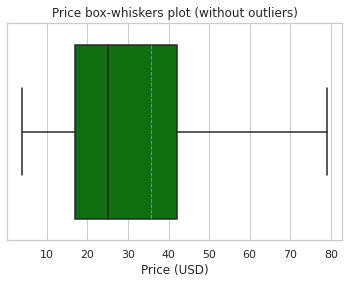

In [ ]:
sns.boxplot(df["price"], color='green', showfliers=False, showmeans=True, meanline=True)
plt.title("Price box-whiskers plot (without outliers)")
plt.xlabel("Price (USD)")

plt.show()

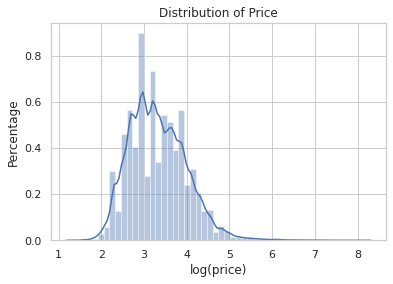

In [ ]:
sns.distplot(np.log(df["price"]), kde=True, norm_hist=True)
plt.title("Distribution of Price")
# plt.xticks(range(80, 101,2))
plt.xlabel("log(price)")
plt.ylabel("Percentage")
plt.show()

### Price vs Score

Now it is time to see if there are any correlations between price and the score of a wine. We will plot points against log(price)

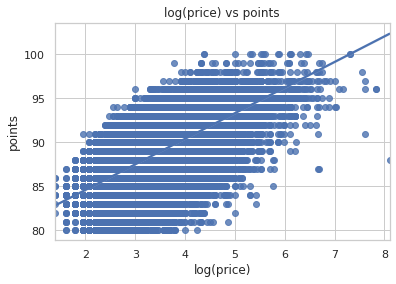

In [ ]:
#Plotting log(price) vs points

sns.regplot(np.log(df['price']), df['points'])
plt.title("log(price) vs points")
plt.xlabel("log(price)")
plt.show()

The graph seems to suggest a roughly logarithmic relationship between price and points, and therefore price does influence the score of a wine to a certain extent. Worth noting however is the large variance, wines at the same price point varying greatly in terms of score. This may hamper the predictive power of price. Additionally, we can see that very expensive wines do worse than what the trend line would suggest for their score

## Description

Wine reviews will be the input for the NLP model (see in below section), so let us visualize via word cloud what keywords might inidicate with high scores (top 5%) and low scores (bottom 5%)

In [ ]:
#define stop words to filter out
stop_words = set(stopwords.words('english')) 

In [ ]:
#Top 5% of wine points
descriptions = df.sort_values("points", ascending=False).head(round(len(df) * 0.05))['description']

#tokenize
tokens = []
for description in descriptions:
  words = word_tokenize(description)
  words = [word.lower() for word in words if word.isalpha()]
  tokens.extend(words)
filtered_tokens = list(filter(lambda word: word not in stop_words, tokens))

#create a counter
token_counter_h = Counter()
for word in filtered_tokens:
  token_counter_h[word] += 1


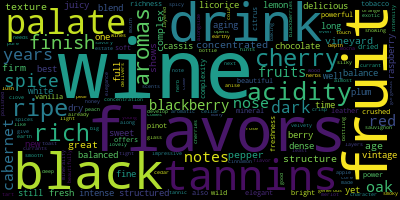

In [ ]:
#Create word cloud for words in reviews of top 5% of wines
wc = WordCloud().fit_words(token_counter_h)
wc.to_image()

In [ ]:
# bottom 5% of wine points
descriptions = df.sort_values("points", ascending=True).head(round(len(df) * 0.05))['description']

#tokenize
tokens = []
for description in descriptions:
  words = word_tokenize(description)
  words = [word.lower() for word in words if word.isalpha()]
  tokens.extend(words)
filtered_tokens = list(filter(lambda word: word not in stop_words, tokens))

#counter
token_counter_l = Counter()
for word in filtered_tokens:
  token_counter_l[word] += 1

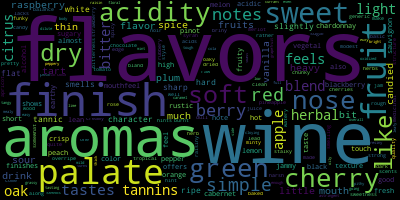

In [ ]:
#Create word cloud for words in reviews of bottom 5% of wines
wc = WordCloud().fit_words(token_counter_l)
wc.to_image()

In [ ]:
# Compare the word frequencies of the most common 50 words from reviews of the top 5% and bottom 5% of wines

#df for top 5%
wc_h_df = pd.DataFrame(np.array(token_counter_h.most_common(50)), columns=['word', 'count'])
wc_h_df['points'] = 'top 5% of wines'

#df for bottom 5%
wc_l_df = pd.DataFrame(np.array(token_counter_l.most_common(50)), columns=['word', 'count'])
wc_l_df['points'] = 'bottom 5% of wines'

wc_df = wc_h_df.append(wc_l_df, ignore_index=True)

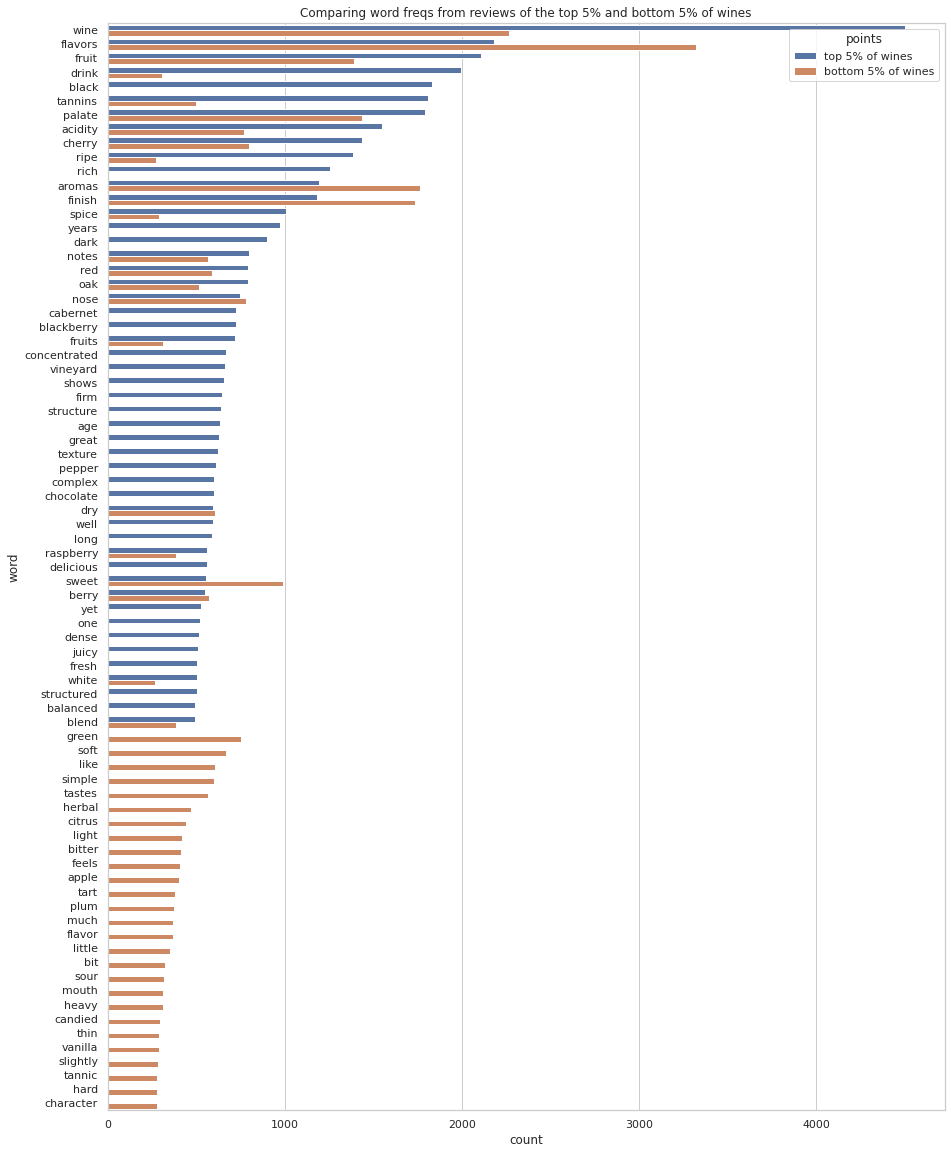

In [ ]:
#bar plot comparing word frequencies
fig, ax = plt.subplots(figsize=(15,20))
sns.barplot(x='count', y='word', hue='points', data=wc_df)
ax.set_title("Comparing word freqs from reviews of the top 5% and bottom 5% of wines")
plt.show()

From the word cloud, it seems like many words overlap. Upon comparing the top 50 most common words in review from the top 5% of wines and bottom 5% of wines, it is clear that there are certain words that both would share a lot in common with one another, such as "wine" and "flavors". However, there are also a significant number of words where there is no overlap, suggesting that some words may correlate with how a wine scores, and many which do overlap appear in noticably different frequencies. Language analysis appears promising.

# Modeling

Four different models are tested and compared, namely, a linear regression, a random forest, a feed forward neural network, and an NLP model. The former three models take as features the country the wine is from, the price, and what variety it is. The latter NLP model takes in text from the wine review. The goal of these models is to predict wine ratings from the input features. The models chosen increase in complexity, and it will be interesting to see if we can tune and create a model that performs better than the baselines. The NLP model is of particular interest because from our EDA, it seems text information could be a good indicator of wine scoring.

The metric used for evaluation is root mean squared error, which is commonly used to measure the error from the predicted value to the actual. Here, the lower the better. Moreover, the RMSE of each model will be compared against the standard deviation, since we previously concluded that the wine ratings were roughly normally distributed, and therefore the standard deviation gives a measure of how much we expect the scores to diverge from the mean (a simplistic predictor of score).

## Data preprocessing

First we need to preprocess the data. Doing so includes:

* Log scale on price
* Downsampling wine variety
* Downsampling country
* One-hot encode country
* One-hot encode wine variety
* Normalize the labels

To recap, price had quite large range, and on log scale some correlation to price could be seen. Both wine variety and country had heavy tail distributions, and a lot of categories, so downsampling based on those was required in order to not blow up the one-hot encoding (which will have implications to efficiency and model complexity). Finally,  normalizing the labels should improve performance as well.

In [ ]:
data = df

# drop non numeric apart from description
data = data.drop(columns=['designation', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'winery'])

In [ ]:
# log scale for price
data['price_log'] = np.log(data['price'])
data = data.drop(columns=['price'])

In [ ]:
# down sample the data to only include from certain countries, where country represents at least 1% of dataset
filtered_country = country_norm[country_norm > 0.01]
print("Num countries over 1%:", len(filtered_country))
print("% of dataset represented: ", filtered_country.sum())

data = data[data['country'].isin(filtered_country.index)]

Num countries over 1%: 12
% of dataset represented:  0.9798339693621024


In [ ]:
# down sample to only include from certain varieties, where each variety is at least 1% of the dataset
filtered_variety = variety_norm[variety_norm > 0.01]

print("Num varieties over 1%:", len(filtered_variety))
print("% of dataset represented: ", filtered_variety.sum())

data = data[data['variety'].isin(filtered_variety.index)]

Num varieties over 1%: 21
% of dataset represented:  0.741965238465573


In [ ]:
#one hot encode country and wine variety

country_one_hot = pd.get_dummies(data['country'], prefix="country")
variety_one_hot = pd.get_dummies(data['variety'], prefix="variety")
data[country_one_hot.columns] = country_one_hot
data[variety_one_hot.columns] = variety_one_hot

data = data.drop(columns=['country', 'variety'])

In [ ]:
#normalize the scores
points_scaled = preprocessing.MinMaxScaler().fit_transform(data['points'].values.reshape(-1,1))
data['points_norm'] = points_scaled

data = data.drop(columns=['points'])

In [ ]:
#separate nlp data from others
nlp_data = data[['description', 'points_norm']]
data = data.drop(columns=['description'])

In [ ]:
label = data['points_norm']
features = data.loc[:, data.columns != 'points_norm']

In [ ]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2)

In [ ]:
#statistics summary for normalized points
points_std = data['points_norm'].std()
data['points_norm'].describe()

count    80702.000000
mean         0.426668
std          0.158409
min          0.000000
25%          0.300000
50%          0.400000
75%          0.550000
max          1.000000
Name: points_norm, dtype: float64

## Models

### Linear Regression

In [ ]:
# running linear regression with scikit-learn

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Linear regression RMSE: ", lr_rmse)

Linear regression RMSE:  0.1211926280715256


From a simple linear regression, we can see that we have already improved upon standard deviation.

### Random Forest



For the random forest, we first tune parameters using grid search. In order to be incremental, we only gave a pairs of parameters to tune each time, starting from number of estimators of 10 and max depth of 5, and doubling each time.

In [ ]:
#using gridsearchCV to tune parameters for random forest

rf = RandomForestRegressor()
params =  {'n_estimators':[80, 100],
           'max_depth':[15, 20]}
clf = GridSearchCV(estimator=rf, param_grid=params)
clf.fit(x_train,y_train)

print(clf.best_params_)

{'max_depth': 15, 'n_estimators': 100}


In [ ]:
# running random forest with scikit-learn

rf = RandomForestRegressor(n_estimators=100, max_depth=15)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Random forest RMSE: ", rf_rmse)

Random forest RMSE:  0.11945334394416621


The random forest model also does better than standard deviation, but seems only marginally better than a linear regression.

### Feed forward neural network

In this section we create a neural network model in order to predict the wine score. This section involves 


1.   Loading the data into data loaders
2.   Defining the neural network model
3. Writing the training and testing loops
4. Executing the training and testing, tuning both the model and hyperparameters



#### Data loader

In [ ]:
#dataset and dataloader
train_dataset = TensorDataset(torch.FloatTensor(x_train.values), torch.FloatTensor(y_train.values))
test_dataset = TensorDataset(torch.FloatTensor(x_test.values), torch.FloatTensor(y_test.values))

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

INPUT_DIM = 34

for idx, data in enumerate(train_loader):
  print(data[0])
  break

tensor([[2.4849, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.1781, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.2581, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [3.4657, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [4.0775, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.9120, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


#### Model definition

In [ ]:
#model which uses two fully connected layers with 64 neurons each

class ff_network(nn.Module):
    def __init__(self):
      super(ff_network, self).__init__()

      self.fc1 = nn.Linear(INPUT_DIM, 64)
      self.fc2 = nn.Linear(64, 64)
      self.fc3 = nn.Linear(64,1)
      self.relu = nn.ReLU()

    def forward(self, x):
      x = self.relu(self.fc1(x))
      x = self.relu(self.fc2(x))
      return self.fc3(x)

#### Train and test loop

In [ ]:
#train test loop

def train_model(train_loader, optimizer, loss_func, model, epochs):
  model.train()
  losses = []
  for epoch in range(epochs):
    num_samples = 0
    total_loss = 0

    for idx, data in enumerate(train_loader):
      optimizer.zero_grad()

      X, y = data[0].cuda(), data[1].cuda()
      batch_size = len(y)
      num_samples += batch_size

      output = model(X)

      loss = loss_func(output, y.unsqueeze(1))
      total_loss += loss.item()

      loss.backward()
      optimizer.step()
    
    print("Epoch: %s Loss: %s"%(epoch+1, total_loss/num_samples))
    losses.append(total_loss/num_samples)
  return losses

def test_model(loader,loss_function,model):
  with torch.no_grad():
    num_samples = 0
    total_loss = 0

    for idx, data in enumerate(loader):

      X, y = data[0].cuda(), data[1].cuda()
      batch_size = len(y)
      num_samples += batch_size

      output = model(X)

      loss = loss_function(output, y.unsqueeze(1))

      total_loss += loss.item()
    print("Test Loss: %s"%(total_loss/num_samples))
  return total_loss/num_samples

#### Training and testing

In [ ]:
ffn_model = ff_network()
ffn_model.cuda()
optimizer = torch.optim.Adam(ffn_model.parameters(), lr=1e-4)
loss_function = nn.MSELoss(reduction='sum')
epochs = 20

loss_per_epoch = train_model(train_loader, optimizer, loss_function, ffn_model, epochs)

Epoch: 1 Loss: 0.020713853519576365
Epoch: 2 Loss: 0.014224930662708588
Epoch: 3 Loss: 0.014110917991385825
Epoch: 4 Loss: 0.01405380384416947
Epoch: 5 Loss: 0.014011929677976345
Epoch: 6 Loss: 0.013992454036863701
Epoch: 7 Loss: 0.013982665063139804
Epoch: 8 Loss: 0.013958694736867554
Epoch: 9 Loss: 0.013951099298269955
Epoch: 10 Loss: 0.013928924617661568
Epoch: 11 Loss: 0.013919348446118696
Epoch: 12 Loss: 0.013923833416130195
Epoch: 13 Loss: 0.013895584923341274
Epoch: 14 Loss: 0.013904633661035183
Epoch: 15 Loss: 0.013894927509341275
Epoch: 16 Loss: 0.013889663046641734
Epoch: 17 Loss: 0.013887498283974882
Epoch: 18 Loss: 0.013874692989879136
Epoch: 19 Loss: 0.013873423630951103
Epoch: 20 Loss: 0.013876306045136818


In [ ]:
nn_rmse = np.sqrt(test_model(test_loader, loss_function, ffn_model))
print("Neural network RMSE: ", nn_rmse)

Test Loss: 0.014183656943765017
Neural network RMSE:  0.11909515919534688


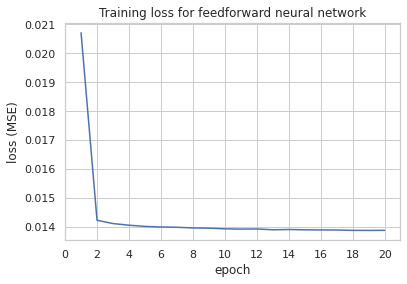

In [ ]:
sns.lineplot(x=list(range(1, epochs + 1)), y=loss_per_epoch)
plt.xlabel("epoch")
plt.ylabel("loss (MSE)")
plt.xticks(np.arange(0, epochs+1,2))
plt.title("Training loss for feedforward neural network")
plt.show()

In terms of training process, there were a number of hyperparameters that were tuned, including the number of epochs and the learning rate. At the default learning rate of 1e-3, the model was converging too quickly and training loss did not improve much across training, so a lower learning rate was selected. The model itself was also tuned, first with a single layer and tuning the number of neurons (doubling from 32 neurons), and then attempting a second layer as well. Ultimately, a network with two fully connected layers asnd 64 neurons was found to perform best.

This model also beats standard deviation, however looks comparable to linear regression and random forest, more discussed in the results section.

### NLP

With the NLP model, we follow the same steps as the neural network. The goal of this model is to process the text in the wine reviews, represent them as a vector, and then predict the wine scores with that as input.

#### Dataset and data loader

In [ ]:
#train test split

msk = np.random.rand(len(nlp_data)) < 0.8
train_df = nlp_data[msk]
test_df = nlp_data[~msk]

In [ ]:
# save to csv to load 
train_df.to_csv("train.csv")
test_df.to_csv("test.csv")

In [ ]:
# defining torchtext data fields, describes how to process data
from torchtext import data

# text data is sequential, and want to lower case everything. use spacy as tokenizer
TEXT = data.Field(sequential=True, tokenize='spacy', lower=True, include_lengths=True)

SCORE = data.Field(sequential=False, use_vocab=False, dtype=torch.float)

In [ ]:
# loading datasets

datafields = [("", None), \
              ("description", TEXT), \
              ("points_norm", SCORE),]

training_data = data.TabularDataset(path='/content/train.csv', \
                                    format='csv',\
                                    fields=datafields, \
                                    skip_header=True)
test_data = data.TabularDataset(path='/content/test.csv', \
                                    format='csv',\
                                    fields=datafields, \
                                    skip_header=True)

In [ ]:
# visualize some of the data
for idx, example in enumerate(training_data):
  if idx > 4:
    break

  print("*******************************")
  print("Review: ", example.description)
  print("Rating: ", example.points_norm)

*******************************
Review:  ['this', 'is', 'ripe', 'and', 'fruity', ',', 'a', 'wine', 'that', 'is', 'smooth', 'while', 'still', 'structured', '.', 'firm', 'tannins', 'are', 'filled', 'out', 'with', 'juicy', 'red', 'berry', 'fruits', 'and', 'freshened', 'with', 'acidity', '.', 'it', "'s", ' ', 'already', 'drinkable', ',', 'although', 'it', 'will', 'certainly', 'be', 'better', 'from', '2016', '.']
Rating:  0.35000000000000053
*******************************
Review:  ['tart', 'and', 'snappy', ',', 'the', 'flavors', 'of', 'lime', 'flesh', 'and', 'rind', 'dominate', '.', 'some', 'green', 'pineapple', 'pokes', 'through', ',', 'with', 'crisp', 'acidity', 'underscoring', 'the', 'flavors', '.', 'the', 'wine', 'was', 'all', 'stainless', '-', 'steel', 'fermented', '.']
Rating:  0.35000000000000053
*******************************
Review:  ['much', 'like', 'the', 'regular', 'bottling', 'from', '2012', ',', 'this', 'comes', 'across', 'as', 'rather', 'rough', 'and', 'tannic', ',', 'with'

In [ ]:
# using glove to create word embeddings, this represents text as tensors

TEXT.build_vocab(training_data, test_data, vectors=GloVe(name='6B', dim=300))

.vector_cache/glove.6B.zip: 862MB [06:30, 2.21MB/s]                           
100%|█████████▉| 399573/400000 [00:53<00:00, 7691.90it/s]

In [ ]:
# see how many words are in the vocabulary
print(len(TEXT.vocab))

27432


In [ ]:
#data loaders

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 64

train_iterator = data.BucketIterator(
    dataset=training_data,
    batch_size=BATCH_SIZE,
    sort_key= lambda x: len(x.description),
    sort_within_batch=True,
    repeat=False,
    shuffle=True,
    device=device
)

test_iterator = data.BucketIterator(
    test_data, 
    batch_size = 1,
    sort=False,
    sort_key = lambda x: len(x.description),
    sort_within_batch = False,
    repeat=False, 
    shuffle=False,
    device = device)

#### NLP model 

In [ ]:
#NLP model: includes an embedding layer that transforms text into tensors, a recurrent layer to give the model
# a sense towards relationships amongst words in a sentence, and a fully connected layer that connects to the output

class NLP_model(nn.Module):
    
    def __init__(self, output_size, hidden_size, vocab_size, embedding_length, word_embeddings):
      super(NLP_model, self).__init__()

      self.output_size = output_size
      self.hidden_size = hidden_size
      self.vocab_size = vocab_size
      self.embedding_length = embedding_length

      # Embedding Layer
      self.embeddings = nn.Embedding(self.vocab_size, self.embedding_length)
      self.embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)

      # Fully-Connected Layer
      self.fc1 = nn.Linear(self.hidden_size, self.output_size)

      # Recurrent Layer
      self.recurrent1 = nn.LSTM(self.embedding_length, self.hidden_size)

    def forward(self, text, text_lengths):
      embedded_text = self.embeddings(text)
      packed_text = nn.utils.rnn.pack_padded_sequence(embedded_text, text_lengths)

      _, hidden_text = self.recurrent1(packed_text)
      hidden_text = hidden_text[0]
      
      x = self.fc1(hidden_text)
      return x

#### Train and test loop

In [ ]:
# train and test loop for NLP model

def train_nlp(dataset_iterator, loss_function, optimizer, model, epochs):
  model.train()
  losses = []
  for epoch in range(epochs):
    total = 0
    total_loss = 0
    for batch in dataset_iterator:
      text, text_lengths = batch.description
      scores = batch.points_norm
      batch_size = len(scores)

      optimizer.zero_grad()
      output = model(text, text_lengths).squeeze(0)
      loss = loss_function(output, scores.unsqueeze(-1))
      loss.backward() 
      optimizer.step()

      total_loss += loss.item()
      total += batch_size

    print("Epoch: %s Loss: %s"%(epoch+1, total_loss/total))
    losses.append(total_loss/total)
  return losses

def test_nlp(dataset_iterator, loss_function, model):
  model.eval()
  total = 0
  total_loss = 0
  for batch in dataset_iterator:
    text, text_lengths = batch.description
    scores = batch.points_norm
    batch_size = len(scores)

    output = model(text, text_lengths).squeeze(0)
    loss = loss_function(output, scores.unsqueeze(-1))

    total_loss += loss.item()
    total += batch_size

  print("Test Loss: %s" % (total_loss/total))
  return (total_loss/total)

#### Training and testing

In [ ]:
# define input dimensions for the model
output_size = 1
vocab_size = len(TEXT.vocab)
embedding_length = TEXT.vocab.vectors.shape[1]
word_embeddings = TEXT.vocab.vectors

In [ ]:
#training and testing the model

hidden_size = 512
nlp_model = NLP_model(output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
nlp_model = nlp_model.to(device)
loss_function = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(nlp_model.parameters(), lr=1e-3)
epochs = 5

loss_per_epoch = train_nlp(train_iterator, loss_function, optimizer, nlp_model, epochs)

100%|█████████▉| 399573/400000 [01:10<00:00, 7691.90it/s]

Epoch: 1 Loss: 0.017848210353508212
Epoch: 2 Loss: 0.00846575314395005
Epoch: 3 Loss: 0.007260881344483494
Epoch: 4 Loss: 0.006583807177400541
Epoch: 5 Loss: 0.006023640797045648


In [ ]:
nlp_rmse = np.sqrt(test_nlp(test_iterator, loss_function, nlp_model))
print("NLP model RMSE: ", nlp_rmse)

Test Loss: 0.006979043781293979
NLP model RMSE:  0.0835406714199376


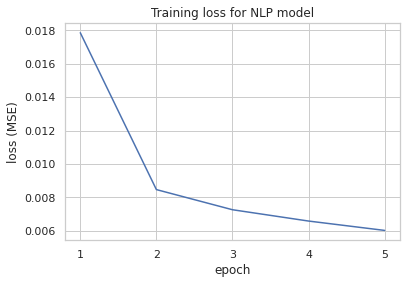

In [ ]:
sns.lineplot(x=list(range(1, epochs + 1)), y=loss_per_epoch)
plt.xlabel("epoch")
plt.ylabel("loss (MSE)")
plt.xticks(np.arange(1, epochs+1))
plt.title("Training loss for NLP model")
plt.show()

For this training process, the hyperparameters tuned were number of epochs, learning rate, and parameters tuned was predominantly the size of the fullcy connected hidden layer. Interestingly, the performance on the test set decreased with an increase of the number of epochs, suggesting overfitting to the training data, hence a smaller number of epochs was chosen. With the hidden size, we started from 128 neurons and doubled them, and came to 512 as the best performing model.

At a cursory glance, the NLP model performs noticably better than the previous three models. More discussed in the results section.

# Results

Here we summarize the performance of the models. We will compare them against simply guessing the mean (whose error can be measured by the standard deviation) as a baseline, and compare them against one another.

Improvement here is defined by the percentage lower of the model's RMSE compared to standard deviation.

In [ ]:
#helper function to calculate percentage change
def pct_change(new, old):
  return abs(new-old)/old

In [ ]:
#collecting results
models = ["Standard deviation", "Linear regression", "Random forest", "Neural network", "NLP"]
performance = [points_std, lr_rmse, rf_rmse, nn_rmse, nlp_rmse]
improvement = list(map(lambda x: pct_change(x, points_std), performance[1:]))

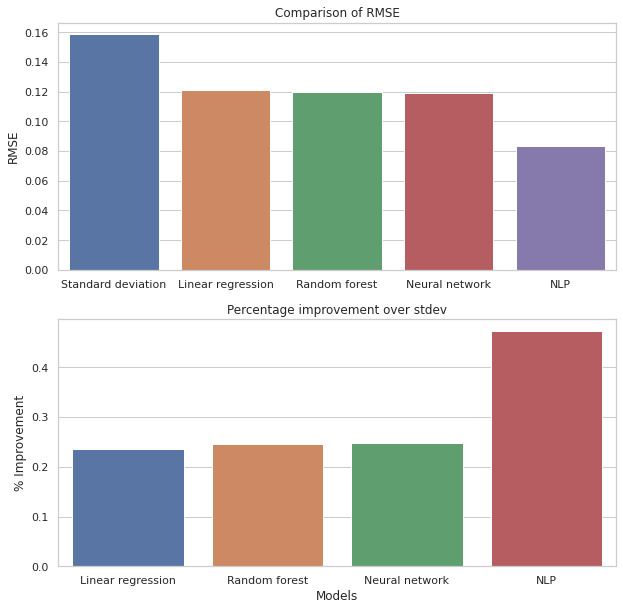

In [ ]:
#plot the RMSE and % improvement of the models
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
sns.barplot(x=models, y=performance, ax=ax1)
sns.barplot(x=models[1:], y=improvement, ax=ax2)

ax1.set_title("Comparison of RMSE")
ax1.set_ylabel("RMSE")

ax2.set_title("Percentage improvement over stdev")
ax2.set_xlabel("Models")
ax2.set_ylabel("% Improvement")

plt.show()

While all models peform better than naive guessing the mean, it is clear that the NLP model outperforms the rest, with over 40% improvement compared to standard deviation. From the above EDA, it seems that there are much more clearly defined and richer features in text that can distinguish a high scoring wine from a low scoring wine, which is reflected in the model's performance.

Genearlly speaking, the more complex the model, the better it performs. The random forest performs better than linear regression, and neural network performs better than random forest. However, amongst these three, the difference is small, all within a small 23-25% improvement compared to standard deviation. Seen from another angle, a simple model such as linear regression performs almost as good as a more complex neural network.

# Closing thoughts


## Challenges

There were a number of challenges faced in modeling this data. Firstly was the large number of discrete categories in certain features; for example there were 42 countries and nearly 700 varieties of wine. Furthermore, these features had a heavy tail class imbalance. The choice was made to remove outliers and classes that represented an disproportionately small amount of the dataset, to prevent models from memorizing these small samples and also to reflect that from small sample sizes it would be unfair to make broad generalizations. The challenge was in deciding where to make cutoffs, and making a tradeoff between including as much information as possible with efficient representation.

Another challenge was building the more complex neural network and NLP models themselves, and then training and tuning parameters/hyperparameters. The challenge was both in the heavier/manual machine learning process that needed to be built, and also in attempting to build a good model by trying different combinations of parameters and hyperparameters.

## Future directions

There are several potential future directions to take this project. First of all, one could tune the amount of downsampling done, and also investigate model training efficiency against degree of downsampling. Next, with a great degree of class imbalance, one could perhaps evaluate models subsampled from certain class features, for example, evaluating only wines from a certain country. Then, more granular detail could be introduced, such as the specific region the wine was made, and it would be interesting to see if those finer geographical details influence wine score. Indeed, a number of these features were omitted in this analysis, however a logical extension would be involving more features. Another way to look at the wine score is to somehow adjust for price, so we could assess the value of said wine and compare how a model for one does against a model for another.